In [1]:
# Import functions and set up plots
%matplotlib inline
import numpy as np       
import datetime as dt    
import pylab as plb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import rc
from matplotlib import rcParams
import glob
import itertools
import datetime
import pandas as pd

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 12}) 
myFmt = md.DateFormatter('%H:%M')
rule = md.MinuteLocator(interval=15)

In [68]:
# Data files

# One day at Summit comparison
CPC_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/CPC_Summit_2019-05-31.csv'
CLASP_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/CLASP_G_Summit_2019-05-31.csv'
SKYOPC_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/SKYOPC_Summit_2019-05-31.csv'
OPCN3_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/Summit_MSF_ICECAPSACE_OPCN3_N1_2019-05-31.csv'


# MSF comparison
#CPC_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/CPC_MSF_2019-05-25.csv'
#CLASP_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/CLASP_G_MSF_2019-05-25.csv'
#SKYOPC_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/SKYOPC_MSF_2019-05-25.csv'
#OPCN3_dfile = '/Users/heather/Desktop/MSF_aerosol_intercomparison/MSF_AQRPI8_OPCN3_N1-OPCN3_N2-OPCN3_N3_20190525.csv'

In [69]:
cpc = pd.DataFrame()
cpc = cpc.append(pd.read_csv(CPC_dfile, header=None, sep=',',error_bad_lines=False))     
cpc[0]= pd.to_numeric(cpc[0],errors='coerce')
cpc[1]= pd.to_numeric(cpc[1],errors='coerce')
cpc[2]= pd.to_numeric(cpc[2],errors='coerce')
cpc[3]= pd.to_numeric(cpc[3],errors='coerce')
cpc[4]= pd.to_numeric(cpc[4],errors='coerce')
cpc[5]= pd.to_numeric(cpc[5],errors='coerce')
cpc.dropna(inplace=True)


cpc[5]=cpc[5].astype(int)

cpc['Date'] = pd.to_datetime(cpc[0].astype(str)+cpc[1].astype(str)+cpc[2].astype(str)+cpc[3].astype(str)+cpc[4].astype(str)+cpc[5].astype(str),format='%Y%m%d%H%M%S')
cpc = cpc.set_index('Date')
cpc['count']=cpc[6] # Counts per cubic cm
del cpc[0],cpc[1],cpc[2],cpc[3],cpc[4],cpc[5],cpc[6]
cpc = cpc.sort_values('Date')
cpc.index = pd.DatetimeIndex(cpc.index)
cpc = cpc[~cpc.index.duplicated()]
cpc['count']=cpc['count'].astype(float)

In [70]:
# Get CLASP data

# Function to import and read CLASP data
def read_clasp(fname):
    f = open(fname)
    d = f.readlines()
    data_block = list(filter(('\n').__ne__, d))
    f.close()
    dates = []
    data = np.empty([len(data_block),16])
    status_parameter = np.empty(len(data_block))
    parameter_val = np.empty(len(data_block))
    ascii_val = np.empty(len(data_block))
    for i in range(0,len(data_block)):
        split = data_block[i].split('\t')
        dates.append(dt.datetime(int(split[0]),int(split[1]),int(split[2]),int(split[3]),int(split[4]),int(split[5])))
        counts = split[6][:-2]
        if '\x00' in counts[0:4]:
            status_parameter[i]=-999
        else:
            status_parameter[i]=float(counts[0:4])
        parameter_val[i]=float(counts[4:10])
        ascii_val[i]=float(counts[10:14])    
        for x in range(0,len(counts[14:].split())):
           data[i,x] = float(counts[14:].split()[x])  
    return(dates,data,status_parameter,parameter_val,ascii_val)    
    
# All CLASP data
# Get all file names
dates1,data1,sp1,p1,ap1 = read_clasp(CLASP_dfile)

all_dates = []
all_data =  np.zeros([0,16])
all_sp =  np.zeros([0])
all_p =  np.zeros([0])
all_ap =  np.zeros([0])

all_dates.append(dates1)
all_data = np.append(all_data,data1,axis=0)
#all_dates.append(dates2)
#all_data = np.append(all_data,data2,axis=0)

all_sp = np.append(all_sp,sp1,axis=0)
#all_sp = np.append(all_sp,sp2,axis=0)

all_p = np.append(all_p,p1,axis=0)
#all_p = np.append(all_p,p2,axis=0)

all_ap = np.append(all_ap,ap1,axis=0)
#all_ap = np.append(all_ap,ap2,axis=0)
    
#flatten dates
CLASP_dates = [y for x in all_dates for y in x]
CLASP_data = all_data
CLASP_total_counts = [sum(x) for x in all_data]



In [71]:
# Get SKYOPC Data
# Measurement interval 6 seconds
# I think C0 = time
# C1 = time + 6 s
# C2 = time + 12 s
# ect.

# 32 channels 
# data output in the unit particle/100ml

# SKYOPC chaneel boundaries:
#0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5,7.5,8.5,10,12.5,15,17.5,20,25,30,32 
#channels 16 and 17 are identical (overlapping 
#channel for different physical measurement ranges)...so one should be 
#discarded before analysis.

#Note also that I think these are diameters not radii - the manual 
#doesn't say!...but in discussion of the calibration it refers only to 
#particle diameter.



# Function to read and import GRIMM OPC data
def read_skyopc(fname):
    f = open(fname)
    d = f.readlines()
    f.close()
    for i in range(0,len(d)):
        line=d[i].split()
        if len(line)<8:
            continue
        if line[0] =='P':
            #Year Mon Day Hr Min Loc 4Tmp Err pA/p pR/p UeL Ue4 Ue3 Ue2 Ue1 Iv 
            datetime = dt.datetime.strptime('20'+line[1]+line[2]+line[3]+line[4]+line[5],'%Y%m%d%H%M')
            quad_Tmp = int(line[7])
            Err = int(line[8])
            pAp = int(line[9])
            pRp = int(line[10])
            Int = int(line[16])
            c=0
        
        elif c==0: 
            ch1=int(line[1])
            ch2=int(line[2])
            ch3=int(line[3])
            ch4=int(line[4])
            ch5=int(line[5])
            ch6=int(line[6])
            ch7=int(line[7])
            ch8=int(line[8])
            c = c+1    
        elif c ==1:
            ch9=int(line[1])
            ch10=int(line[2])
            ch11=int(line[3])
            ch12=int(line[4])
            ch13=int(line[5])
            ch14=int(line[6])
            ch15=int(line[7])
            ch16=int(line[8])
            c = c+1
        elif c == 2:
            ch17=int(line[1])
            ch18=int(line[2])
            ch19=int(line[3])
            ch20=int(line[4])
            ch21=int(line[5])
            ch22=int(line[6])
            ch23=int(line[7])
            ch24 =int(line[8])
            c= c+1
        elif c==3:
            ch25=int(line[1])
            ch26=int(line[2])
            ch27=int(line[3])
            ch28=int(line[4])
            ch29=int(line[5])
            ch30=int(line[6])
            ch31=int(line[7])
            ch32=int(line[8])
            c = 0
            n = int(line[0][-2])
            if i<5:
                GRIMM_data = np.array([datetime+dt.timedelta(seconds=n*6), ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13, ch14, ch15, ch16, ch17, ch18, ch19, ch20, ch21, ch22, ch23, ch24, ch25, ch26, ch27, ch28, ch29, ch30, ch31, ch32, quad_Tmp,Err,pAp,pRp,Int])
            else:
                GRIMM_data = np.vstack((GRIMM_data,np.array([datetime+dt.timedelta(seconds=n*6), ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13, ch14, ch15, ch16, ch17, ch18, ch19, ch20, ch21, ch22, ch23, ch24, ch25, ch26, ch27, ch28, ch29, ch30, ch31, ch32, quad_Tmp,Err,pAp,pRp,Int])))

    return GRIMM_data

skyopc_data = read_skyopc(SKYOPC_dfile)
skyopc = pd.DataFrame(data=skyopc_data,columns=['Date','ch1' ,'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8', 'ch9', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch16', 'ch17', 'ch18', 'ch19', 'ch20', 'ch21', 'ch22', 'ch23', 'ch24', 'ch25', 'ch26', 'ch27', 'ch28', 'ch29', 'ch30', 'ch31', 'ch32', 'quad_Tmp','Err','pAp','pRp','Int'])
skyopc.dropna(inplace=True)
skyopc = skyopc.set_index('Date')
skyopc = skyopc.sort_values('Date')
skyopc.index = pd.DatetimeIndex(skyopc.index)
skyopc = skyopc[~skyopc.index.duplicated()]
# Change hour to an hour behind
skyopc.index = skyopc.index - pd.Timedelta(hours=1)
# remove repeated channel 16
del skyopc['ch16']


In [72]:
# Get OPC-N3 Data

def ExtractOPCdata(dfiles,sens):
    """
    Functions to extract multiple OPC data from same CSV file, put them into seperate DataFrame all in one dic.
    Works for up to 4 sensors. IF more are attaced at another elif to the 2nd loop
    
    28/05/2019
    """
    
    OPCdata={} #Data dictionary
    OPCcols={} #columns dictionary to get the right data from each sensors
    
    
    #for loop for the amount sensors running
    for sen in sens:
        OPCdata[sen]=pd.DataFrame()
        OPCcols[sen]=[]
    
    #Read file for loop
    for file in dfiles:
        dataloop=pd.read_csv(file,header=4,error_bad_lines=False,engine='python')
        dataloop.set_index('time', inplace=True, drop=True)
        # print(dataloop.head(4))
        #seprate columns 
        
        #2nd loop though columns, seprationg them for diffrent sensors
        for col in dataloop.columns:
         #can account for 4 OPCN3   
            if ".1" in col:
                OPCcols[sens[1]].append(col)
            elif ".2" in col:
                OPCcols[sens[2]].append(col)
            elif ".3" in col:
                OPCcols[sens[3]].append(col)
            else:
                OPCcols[sens[0]].append(col)
        #2 print(OPCcols)
        #3rd Concat to the OPCdata data frames
        for sen in sens:
            #concat for the data dictionary 
            #3 print(sen,OPCcols[sen],OPCdata[sen])
            
            data=pd.concat([OPCdata[sen],dataloop[OPCcols[sen]]], ignore_index=False, axis=0,sort=True)  
            #3 print(data.head(4))
            for col in data.columns:
                #loop though colums getting rid of the .1 or .2 for multiple sensors 
                if "." in col:
                    a=col.find(".")
                    data.rename(columns={col:col[0:a]},inplace=True)
            data.rename(columns={"pm2":"pm2.5"},inplace=True)
            
            OPCdata[sen]=data
            
    return OPCdata

sens=["OPCN3_1"]#,"OPCN3_2","OPCN3_3"]    
OPCdata=ExtractOPCdata([OPCN3_dfile],sens)
OPC1 = OPCdata['OPCN3_1']
#OPC2 = OPCdata['OPCN3_2']
#OPC3 = OPCdata['OPCN3_3']

OPC1.index = pd.DatetimeIndex(OPC1.index)
#OPC2.index = pd.DatetimeIndex(OPC2.index)
#OPC3.index = pd.DatetimeIndex(OPC3.index)

# Change hour to an hour behind
OPC1.index = OPC1.index - pd.Timedelta(hours=1)
#OPC2.index = OPC2.index - pd.Timedelta(hours=1)
#OPC3.index = OPC3.index - pd.Timedelta(hours=1)

# Convert flow rate from L/min to cm3/s
# 1 L/min = 16.66667 cm3/s
OPC1.FlowRate = OPC1.FlowRate/100 * 16.66667
#OPC2.FlowRate = OPC2.FlowRate/100 * 16.66667
#OPC3.FlowRate = OPC3.FlowRate/100 * 16.66667

# Get total counts
OPC1['total_counts']=OPC1['b0'].astype(float)+ OPC1['b1'].astype(float)+ OPC1['b2'].astype(float)+ OPC1['b3'].astype(float)+ OPC1['b4'].astype(float)+ OPC1['b5'].astype(float)+ OPC1['b6'].astype(float)+ OPC1['b7'].astype(float)+ OPC1['b8'].astype(float)+ OPC1['b9'].astype(float)+ OPC1['b10'].astype(float)+ OPC1['b11'].astype(float)+ OPC1['b12'].astype(float)
#OPC2['total_counts']=OPC2['b0'].astype(float)+ OPC2['b1'].astype(float)+ OPC2['b2'].astype(float)+ OPC2['b3'].astype(float)+ OPC2['b4'].astype(float)+ OPC2['b5'].astype(float)+ OPC2['b6'].astype(float)+ OPC2['b7'].astype(float)+ OPC2['b8'].astype(float)+ OPC2['b9'].astype(float)+ OPC2['b10'].astype(float)+ OPC2['b11'].astype(float)+ OPC2['b12'].astype(float)
#OPC3['total_counts']=OPC3['b0'].astype(float)+ OPC3['b1'].astype(float)+ OPC3['b2'].astype(float)+ OPC3['b3'].astype(float)+ OPC3['b4'].astype(float)+ OPC3['b5'].astype(float)+ OPC3['b6'].astype(float)+ OPC3['b7'].astype(float)+ OPC3['b8'].astype(float)+ OPC3['b9'].astype(float)+ OPC3['b10'].astype(float)+ OPC3['b11'].astype(float)+ OPC3['b12'].astype(float)


# Convert total counts/interval to total counts/s
OPC1.period = OPC1.period/100 # period in s
OPC1.total_counts = OPC1.total_counts /OPC1.period
#OPC2.period = OPC2.period/100 # period in s
#OPC2.total_counts = OPC2.total_counts /OPC2.period
##OPC3.period = OPC3.period/100 # period in s
#OPC3.total_counts = OPC3.total_counts /OPC3.period

# Convert total counts/second to counts/cm3
OPC1['TotalConc'] = OPC1.total_counts / OPC1.FlowRate
#OPC2['TotalConc'] = OPC2.total_counts / OPC2.FlowRate
#OPC3['TotalConc'] = OPC3.total_counts / OPC3.FlowRate

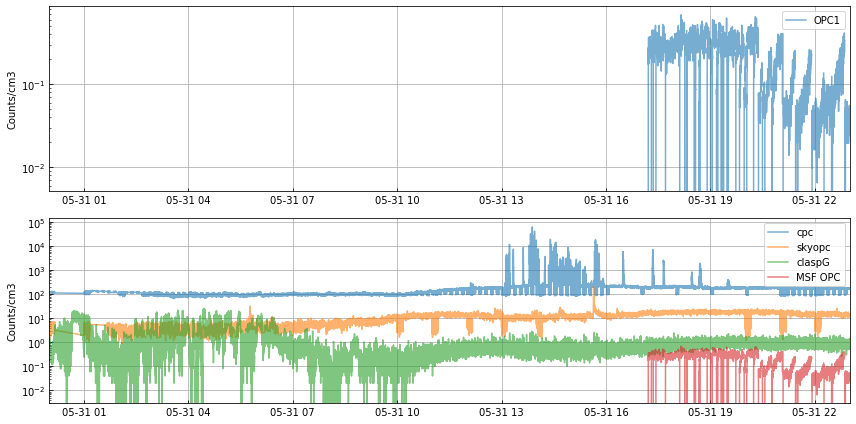

In [76]:
# Plot counts versus time in counts/cm3

# CPC already in counts/cm3/s

# CLASP
# CLASP-G flowrate = 3L/minute = 50 cm3/second
# Units: particle counts/ sample interval
# Sample interval: 1s
# Calculate total counts
# Calculate concentation
CLASP_conc = np.asarray(CLASP_total_counts) / 50 #counts/cm3


# SKYOPC
# Units: counts/100ml == 100 counts/cm3
# Calculate total counts/cm3 by adding bins
skyopc['total_counts']=skyopc['ch1']+skyopc['ch2']+skyopc['ch3']+skyopc['ch4']+skyopc['ch5']+skyopc['ch6']+skyopc['ch7']+skyopc['ch8']+skyopc['ch9']+skyopc['ch10']+skyopc['ch11']+skyopc['ch12']+skyopc['ch13']+skyopc['ch14']+skyopc['ch15']+skyopc['ch17']+skyopc['ch18']+skyopc['ch19']+skyopc['ch20']+skyopc['ch21']+skyopc['ch22']+skyopc['ch23']+skyopc['ch24']+skyopc['ch25']+skyopc['ch26']+skyopc['ch27']+skyopc['ch28']+skyopc['ch29']+skyopc['ch30']+skyopc['ch31']+skyopc['ch32']
# Assuming 6 second integration
skyopc['total_counts']=skyopc['total_counts']/100 #counts/cm3
skyopc['total_counts']=skyopc['total_counts'].astype(float)

# OPC's
# Flowrates:
# 1: 0.510 L/min = 8.5 cm3/s
# 2: 0.565 L/min = 9.42
# 3: 0.587 L/min = 9.78
# Calculate total counts/10sec?? or counts/second?


fig = plt.figure(figsize=[12,6])

ax1 = fig.add_subplot(211)
ax1.semilogy(OPC1.index,OPC1.TotalConc,label='OPC1',alpha=0.6)
#ax1.semilogy(OPC2.index,OPC2.TotalConc,label='OPC2',alpha=0.6)
#ax1.semilogy(OPC3.index,OPC3.TotalConc,label='OPC3',alpha=0.6)
ax1.grid('on')
ax1.set_ylabel('Counts/cm3')
ax1.legend()



ax2 = fig.add_subplot(212)
ax2.semilogy(cpc.index,cpc['count'],label='cpc',alpha=0.6)
ax2.semilogy(skyopc.index,skyopc['total_counts'],label='skyopc',alpha=0.6)
ax2.semilogy(CLASP_dates,CLASP_conc,label='claspG',alpha=0.6)
ax2.semilogy(OPC1.index,OPC1.TotalConc,label='MSF OPC',alpha=0.6)
#ax2.semilogy(OPC1.index,np.nanmean((np.asarray(OPC1.TotalConc),np.asarray(OPC2.TotalConc),np.asarray(OPC3.TotalConc)),axis=0),label='OPC Mean',alpha=0.6)
ax2.grid('on')
ax2.set_ylabel('Counts/cm3')
ax2.legend(loc='upper right')

# Format ticks and labels and layout
ax1.set_xlim(dt.datetime(2019,5,31,0),dt.datetime(2019,5,31,23))
ax2.set_xlim(dt.datetime(2019,5,31,0),dt.datetime(2019,5,31,23))
#ax1.set_ylim(0,4000)
#ax1.xaxis.set_major_locator(rule)
#ax1.xaxis.set_minor_locator(minor)
#ax1.xaxis.set_major_formatter(myFmt)
#ax2.xaxis.set_major_locator(rule)
#ax1.xaxis.set_minor_locator(minor)
#ax2.xaxis.set_major_formatter(myFmt)
fig.tight_layout()



In [67]:
# Compare Spectra - to do this don't you have to divide by bin size? dN/dr or something? 


In [44]:

# selects all rows and all columns beginning at 'foo' up to and including 'sat'
OPC_bins = OPC1.loc[:, 'b0':'b9']



#OPC_cols = ['b0','b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','b12']
#OPC1.hist(column=OPC_cols)

In [57]:
opc_bins = OPC_bins.sum(axis=0)
opc_bins_final = [opc_bins['b0'],opc_bins['b1'],opc_bins['b2'],opc_bins['b3'],opc_bins['b4'],opc_bins['b5'],opc_bins['b6'],opc_bins['b7'],opc_bins['b8'],opc_bins['b9'],opc_bins['b10'],opc_bins['b11'],opc_bins['b12'],opc_bins['b13'],opc_bins['b14'],opc_bins['b15'],opc_bins['b16'],opc_bins['b17'],opc_bins['b18'],opc_bins['b19'],opc_bins['b20'],opc_bins['b21'],opc_bins['b22'],opc_bins['b23'],]

<BarContainer object of 24 artists>

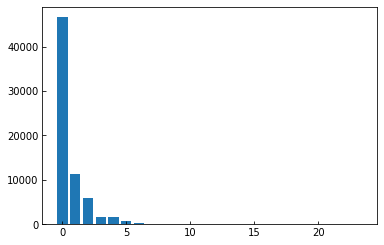

In [66]:
plt.bar(np.arange(0,24,1),opc_bins_final)

In [65]:
np.arange(0,24,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])